In [3]:
suppressPackageStartupMessages(library(dplyr)) # data manipulation
library(DT) # interactive tables
suppressPackageStartupMessages(library(gganimate)) # animation
library(ggforce) # extended graphing
library(ggplot2) # standard graphing
suppressPackageStartupMessages(library(gridExtra)) # arranging plots
library(matrixcalc) # matrix zero-padding
library(tidyr) # data manipulation
suppressPackageStartupMessages(library(viridis)) # colourblind-friendly palette

## Introduction

Darts is a game of incredible skill and precision. If however - like me - you lack the necessary coordination to shine at the sport, luck will have to suffice. Then, if things happen to go your way, all you are left to do is claim deliberateness. In fact, there is a truth to this for all players, newcomers and seasoned professionals alike. All abilities will have some natural variation between each throw giving rise to a probability distribution reflecting where the dart landed relative to where it was aimed. After all, no one is guaranteed to hit exactly where they wanted.

This raises the question, if you want to maximise your score in a given throw, where is it best to aim? We start with the extremes. If you were some sort of superhuman darts-ninja guaranteed to hit exactly where you aim, there is no doubt that you would simply aim for the treble 20 on every throw. Ultimately, it's the highest possible score you can get on the board and since you're certain to hit it if you try, it would be foolish to aim anywhere else. On the contrary, suppose you are a complete darts rookie, playing with your off-hand during a magnitude 7.6 earthquake. You'd be quite chuffed if you even managed to get it on the board, never mind what score you get. Since you are so unlikely to do even this, to maximise your score you need to have the highest chance of just getting on the board. This will be achieved by aiming at the centre. We now have our two extremes, the perfect player should always aim for treble 20 whereas a hopeless player should aim for the centre. But this still leaves us to ask what the best strategy is for any player in between these edge-cases.

## Modelling the Problem

### The Dartboard

We will be looking at the [regulation dartboard](https://commons.wikimedia.org/wiki/File:Dartboard.svg), envisioned by Brian Gramlin in 1896. The numbers are ordered in such a way they they punish inaccuracy; if you aim for the highest score - 20 - and miss, you could easily end up with the lowest - 1. The standard radii for the rings according the British Darts Organisation are 6.4 mm, 16.0 mm, 99.0 mm, 107.0 mm, 162.0 mm and 170.0 mm with the radius of the whole board being 225 mm. These are the dimensions we'll use for our model.

### Throw Distribution

We will need to model the random nature of a dart throw by some sort of probability distribution. But what sort of distribution might we expect to see? A promising candidate would be modelling the horizontal and vertical displacement of the dart's actual target from the intended one by two independent and identically distributed normal random variables. The normal distribution is a bell shaped curve which is often used for modelling errors so is highly suitable for this purpose. If we set the parameter $\mu$ to zero then the joint density function of the two random variables will be highest at the point where the player aims and then tail off as you get further away, equally so in all directions. This is the exact behaviour we would expect to see in the real world; no matter what your ability is at darts you'll always be more likely to hit closer to where you were aiming than further. The standard deviation parameter, $\sigma$, will control how spread out the dart is likely to be from where it is intended. A good player would have a small standard deviation whereas a bad player would have a larger one resulting in a wider and flatter density curve. This is the same as saying that a good player is more likely to hit near to where they were aiming whilst a bad player has a higher likelihood to be further away.

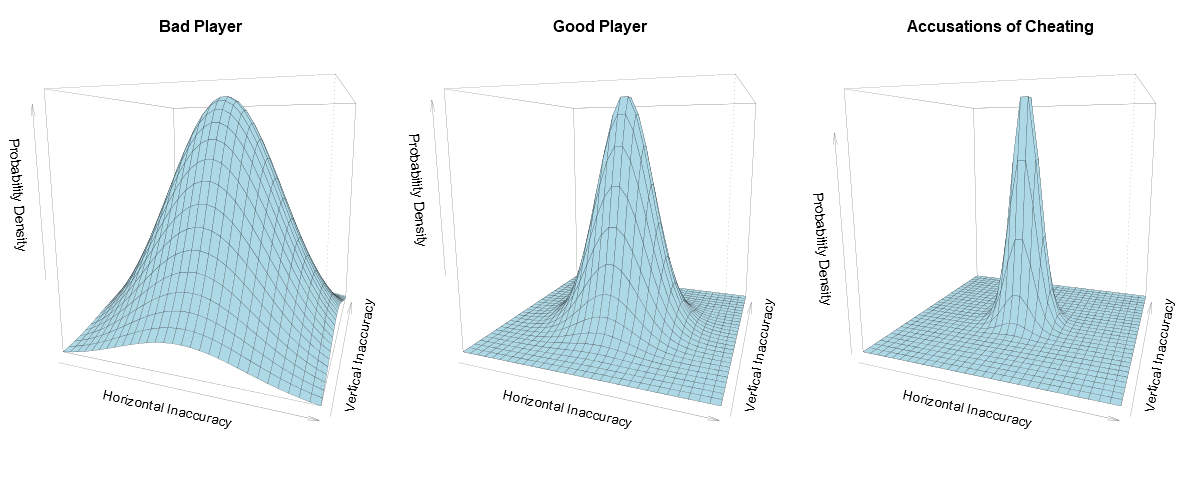

In [4]:
options(repr.plot.width=10, 
        repr.plot.height=4,
        jupyter.plot_mimetypes = "image/png")

par(mfrow = c(1,3), mar = c(0, 2, 0, 2))
resolution = 30

xSeq <- seq(-2, 2, length.out = resolution)
ySeq <- seq(-2, 2, length.out = resolution)

dnorm2D <- function(x,y, sd = 1) 1/(2*pi*sd^2) * exp(-(x^2 + y^2)/(2*sd^2))

badPlayer <- outer(xSeq, ySeq, dnorm2D, sd = 1)
goodPlayer <- outer(xSeq, ySeq, dnorm2D, sd = 0.5)
cheat <- outer(xSeq, ySeq, dnorm2D, sd = 0.25)

normalPlot <- function(z) persp(x = xSeq, y = ySeq, z = z, theta = 20, phi = 10,
      zlab = "\nProbability Density", xlab = "\nHorizontal Inaccuracy", 
      ylab = "\nVertical Inaccuracy", col = "lightBlue", lwd = 0.1)

normalPlot(badPlayer)
title("Bad Player", line = -2)
normalPlot(goodPlayer)
title("Good Player", line = -2)
normalPlot(cheat)
title("Accusations of Cheating", line = -2)

This model is not a perfect reflection of reality. However, what we lose in accuracy we gain in simplicity which will come important later when we start using this model for computations. A handful of critiques and improvements are:

* There is no reason to believe that the standard deviation for the horizontal and vertical errors should be the same. It is reasonable to imagine that they would be similar but since you are having to counteract the affect of gravity when considering the vertical accuracy of your shot, this added layer of complexity may make the standard deviation slightly higher.
* The normal distribution is perfectly symmetrical but it is most likely not the case that this be true for the distribution of errors of a real player. The left or right-handedness of the player may give the distribution for the horizontal error a skew in a particular direction and the influence of gravity may do the same for the vertical component.
* Lastly, our assumption of the independence of the vertical and horizontal errors may not be justified. Perhaps if you mess up your horizontal aim, say due to shaky hand, you may be more likely to also mess up the vertical. 

Despite these possible discrepancies, we continue in the belief that our basic model is as accurate a reflection of real life as we need for any non-pathological cases.

## Forming a Strategy

### Calculating Scores

To begin, we will need a function which can convert a pair of Cartesian coordinates representing the location a dart lands to the respective score at that point. Due to the pattern-less nature of the numbers' order we will have to do this directly.

In [5]:
calcScore <- function(x, y) {
  
  # concert to polar coordinates
  r <- sqrt(x^2 + y^2)
  if (r == 0) {
    theta <- 0
  } else {
    theta <-  atan2(y, x)
  }
  
  # transform so zero is on the boundary of 20 and 1 
  # and the angle increases as we go clockwise
  phi <- pi / 2 - theta - pi / 20
  
  # find what region the angle is in; 
  # e.g. region 1 is 0-18°, region 2 is 18°-36° etc.
  region <- findInterval(phi %% (2 * pi), 
                         seq(0, by = pi/10, length.out = 20))
  
  # find score for that region
  regionScore <- c(1, 18, 4, 13, 6, 10, 15, 2, 17, 3,
                    19, 7, 16, 8, 11, 14, 9, 12, 5, 20)[region]
  
  # find which ring the dart is in
  ring <- findInterval(r, c(0, 6.4, 16, 99, 107, 162, 170, Inf))
  
  # calculate final score
  score <- switch(ring,
                  50,
                  25,
                  regionScore,
                  3 * regionScore,
                  regionScore,
                  2 * regionScore,
                  0)
  
  return(score)
}

In [6]:
# vectorise the function for use in outer()
calcScore <- Vectorize(calcScore)

The best way to visualise this data is using a heat-map.

In [7]:
# code for formatting plots to look like a dartboard using ggforce
# saving the changes in a list object to be call when plotting
circles.df <- data.frame(
    x0 = rep(0, 6),
    y0 =  rep(0, 6),
    r = c(6.4, 16, 99, 107, 162, 170)
)

arcs.df <- data.frame(
    x = sapply(1:20, function(x) 16 * cos(x * pi / 10 + pi / 20)),
    y =  sapply(1:20, function(x) 16 * sin(x * pi / 10 + pi / 20)),
    xend = sapply(1:20, function(x) 170 * cos(x * pi / 10 + pi / 20)),
    yend = sapply(1:20, function(x) 170 * sin(x * pi / 10 + pi / 20))
)

labels.df <- data.frame(
    x = sapply(1:20, function(x) 135 * sin(x * pi / 10)),
    y =  sapply(1:20, function(x) 135 * cos(x * pi / 10)),
    label = c(1, 18, 4, 13, 6, 10, 15, 2, 17, 3,
                    19, 7, 16, 8, 11, 14, 9, 12, 5, 20)
)

dart_board_layout <- list(
  geom_circle(data = circles.df, aes(x0 = x0, y0 = y0, r = r), size = 1),
  geom_segment(data = arcs.df, aes(x = x, y = y, xend = xend, yend = yend), size = 1),
  geom_text(data = labels.df, aes(x = x, y = y, label = label), fontface = "bold", size = 8),
  coord_fixed(expand = FALSE),
  labs(x = "Horizontal Displacement From Centre (mm)",
       y = "Vertical Displacement From Centre (mm)",
       fill = "Score"),
  scale_fill_viridis(),
  theme(axis.text = element_blank(), axis.ticks = element_blank())
)

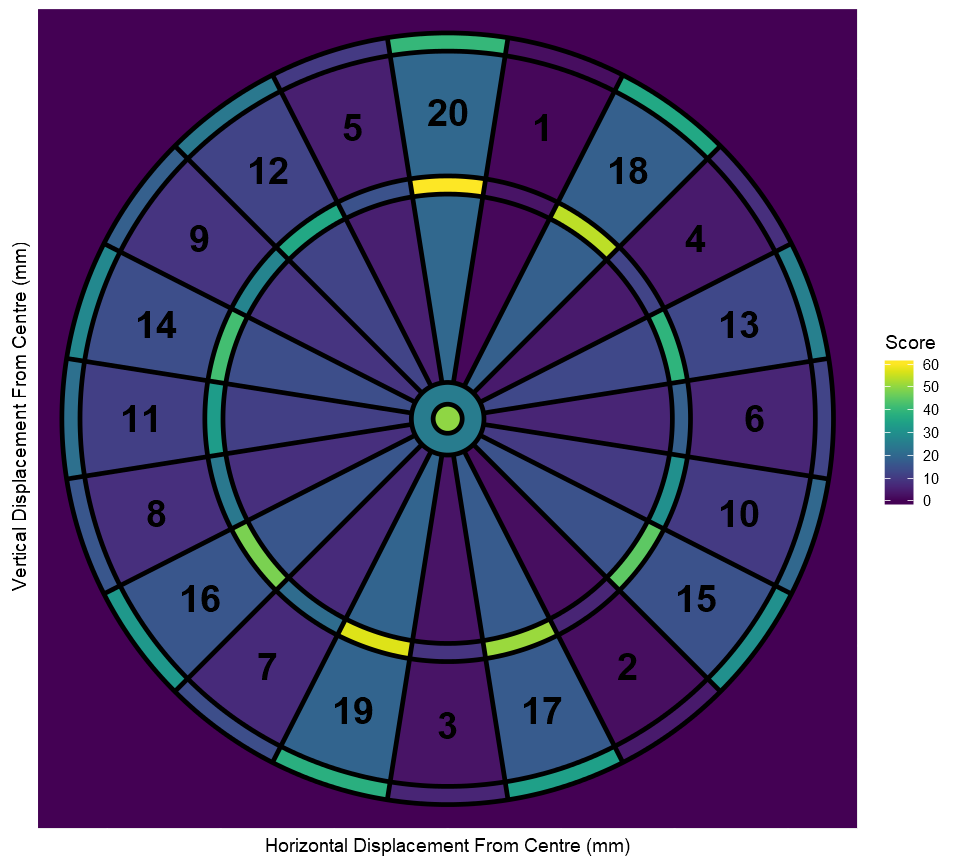

In [8]:
options(repr.plot.width=8, 
        repr.plot.height=7.2,
        jupyter.plot_mimetypes = "image/png")

# above code is computationally expensive so use 
# pre-computed values for compiling the blog post
values <- -180:180
score <- readRDS(file = "Resources/darts_1.rds")
score.df <- data.frame(x = rep(-180:180, times = 361),
                       y = rep(-180:180, each = 361),
                       z = as.vector(score))

ggplot() +
  geom_raster(data = score.df, aes(x = x, y = y, fill = z)) +
  dart_board_layout

### Calculating Expectations

We can use this score function alongside the density function for the 2D normal distribution to find the expected score attained by aiming at any location on the board for a given standard deviation. To find this expected value we simply centre our normal distribution at the point that is aimed at, then integrate the product of the density function and the score function over the entire board. We then sweep the distribution over the whole board to get the expected value at each point. 

In a perfect world we would compute this integral directly and to the highest precision our computer can store. In reality this process is extremely time consuming. In my preparation for this post, I developed such a method and even with the use of time-saving short-cuts and tight coding the program took over an hour to run for some larger standard deviations. Since the end goal is to compute this for many standard deviations, this is not a feasible approach. 

Instead, I got out my pen and paper and went about finding an approximation method which would give only a negligibly different result to the true value but would be much more computable. I decided in the end to split dartboard up into a 361x361 grid (essentially a 1mm x 1mm grid). There was nothing special mathematically about these exact dimensions - they just worked well with the code - and after some long-winded analysis and a touch of brute force computations, I concluded that for standard deviations of at most 110 this method would be accurate to the integer, which for this use is all we need. This is quite a weak bound so in reality the method will be a lot closer to the true solution but in the worst possible case we know that it is at least that good. In practice, if your standard deviation is any more than 100mm then there is no doubt that you should be aiming for the centre of the board.

We can package up this method in a neat little function so we can easily reuse it for any standard deviation.

In [9]:
expectationMtrx <- function(sd) {
  # values used to approximate integral
  values <- -180:180
  
  # compute values of 2D normal density at approximating points
  density_mtrx <- outer(values, values, function(x, y){
    dnorm(x, 0, sd) * dnorm(y, 0, sd)
  })
  
  # compute scores at approximating points
  score_mtrx <- outer(values, values, calcScore)
  
  # pad with zeros on all sides
  zero_mtrx <- matrix(0, nrow = 361, ncol = 361)
  score_mtrx <- direct.sum(direct.sum(zero_mtrx, score_mtrx), 
                           zero_mtrx)
  
  # matrix to hold expected values
  expectationMatrix <- matrix(0, nrow = 361, ncol = 361)
  
  # sweep distribution matrix over the board
  for (i in 1:361) {
    for (j in 1:361) {
      # which subest of the score matrix to multiply with the density
      score_mtrx.subset <- score_mtrx[i + 361 + values, j + 361 + values]
      
      # contibution to expected value at approximating point
      contrib <- sum(score_mtrx.subset * density_mtrx)
      expectationMatrix[i, j] <- contrib
    }
  }
  
  return(expectationMatrix)
}

## Visualising the Expectations

### Static visualisations

We can now call this function for any standard deviation up to 110 and get back a matrix giving the expected score we'd achieve for aiming at any location on the data board with that level of accuracy. Let's generate these matrices for a selection of standard deviations and visualise the results.

In [10]:
# more formatting code but for smaller facetted plots
dart_board_layout_small <- list(
  geom_circle(data = circles.df, aes(x0 = x0, y0 = y0, r = r), size = 0.5),
  geom_segment(data = arcs.df, aes(x = x, y = y, xend = xend, yend = yend), size = 0.5),
  geom_text(data = labels.df, aes(x = x, y = y, label = label), fontface = "bold", size = 3.5),
  coord_fixed(expand = FALSE),
  labs(x = "Horizontal Displacement From Centre (mm)",
       y = "Vertical Displacement From Centre (mm)",
       fill = "Score"),
  scale_fill_viridis(limit = c(0, 60)),
  theme(axis.text = element_blank(), axis.ticks = element_blank())
)

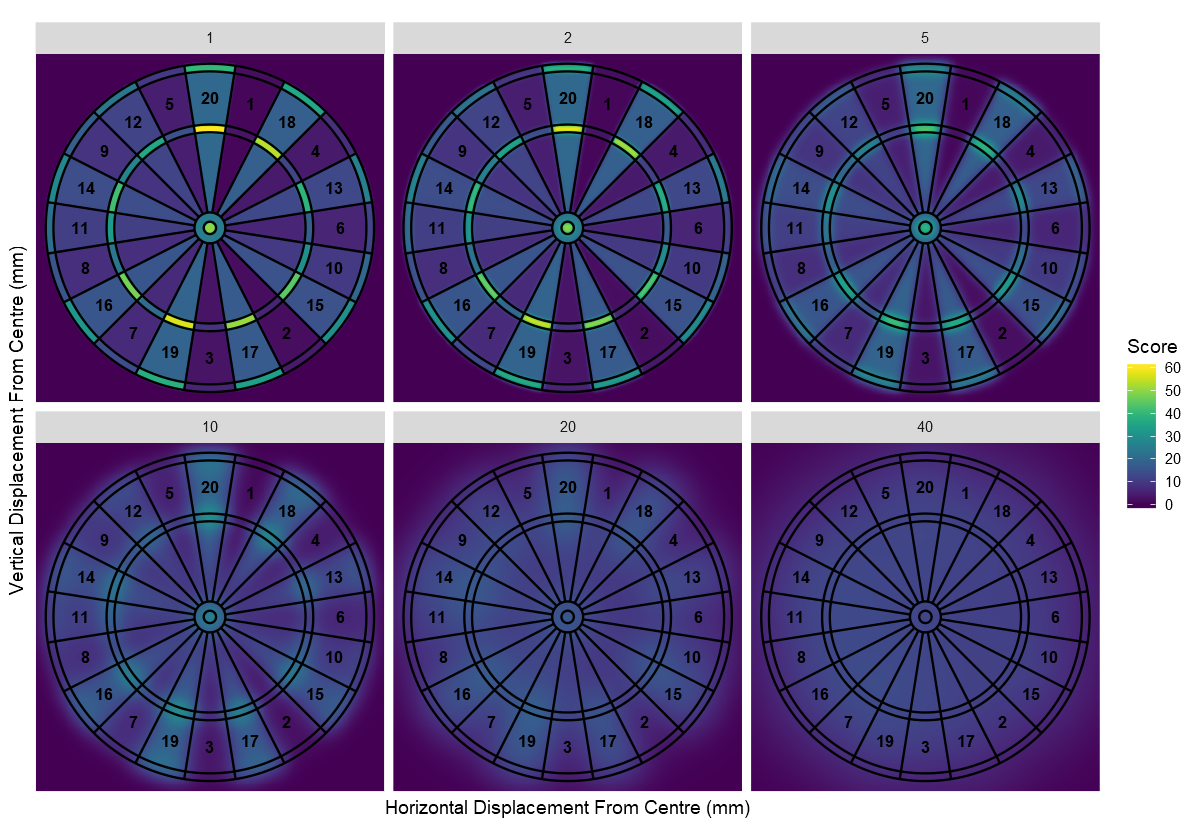

In [11]:
options(repr.plot.width=10, 
        repr.plot.height=7,
        jupyter.plot_mimetypes = "image/png")

# above code is computationally expensive so use 
# pre-computed values for compiling the blog post
computed_maps <- readRDS(file = "Resources/darts_2.rds")

# convert matrices into tidy data frames and store in a list
dfs <- lapply(c(1, 2, 5, 10, 20, 40), function(sd) {
  data.frame(x = rep(-180:180, times = 361),
             y = rep(-180:180, each = 361),
             z = as.vector(computed_maps[[sd]]),
             sd = sd)
})

# combine the data frames together
expectation.df <- do.call(rbind, dfs)
  
# plot the heatmaps, facetted by standard deviation
ggplot() +
  geom_raster(data = expectation.df, aes(x = x, y = y, fill = z)) +
  dart_board_layout_small +
  facet_wrap(~ sd, ncol = 3)

### Animated visualisations

These plots are interesting by themselves but don't tell the whole story. What we really need is an animation to show how the heat-map changes as the standard deviation increases, and more importantly, how this affects the optimum location to aim and the expected score corresponding to it. We produce such an animation using the `gganimate` package. 

In [12]:
# convert matrices into tidy data frames and store in a list
dfs <- lapply(1:100, function(sd) {
  data.frame(x = rep(-180:180, times = 361),
             y = rep(-180:180, each = 361),
             z = as.vector(computed_maps[[sd]]),
             sd = sd)
})

# combine data frames together
expectation.df <- do.call(rbind, dfs)

# find which points are opitimum for each standard deviation
optimums <- expectation.df %>%
  group_by(sd) %>%
  filter(z == max(z)) %>%
  ungroup() %>%
  # multiple optimums for sd = 1 so choose one matching sd = 2
  filter(sd != 1 | (x == 0 & y == 102))

In [13]:
# warning: takes a long time to render
if (FALSE) {
    ###########################################################################
    ## NB: gganimate::animate() now has parameters start_pause and end_pause ##
    ## which was not the case at the time of writing this post. I will keep  ##
    ## this code in to show an alternate manual workaround.                  ##
    ###########################################################################

    # add pause at beginning and end of animation
    expectation.df.pause <- expectation.df %>%
      mutate(frame_len = case_when(sd == 1 ~ 11,
                                   sd == max(sd) ~ 6,
                                   TRUE ~ 1)) %>%
      # tidyr::uncount() copies each line 'n' times
      uncount(frame_len) %>%
      # split duplicates into frames
      group_by(x, y) %>%
      mutate(frame = row_number(sd)) %>%
      ungroup()

    optimums.pause <- optimums %>%
      mutate(frame_len = case_when(sd == 1 ~ 11,
                                   sd == max(sd) ~ 6,
                                   TRUE ~ 1)) %>%
      # tidyr::uncount() copies each line 'n' times
      uncount(frame_len) %>%
      # split duplicates into frames
      mutate(frame = row_number(sd))

    # generate heat maps
    ggplot() +
      geom_raster(data = expectation.df.pause, aes(x = x, y = y, fill = z)) +
      dart_board_layout +
      geom_point(data = optimums.pause, aes(x = x, y = y), col = "white") +
      geom_text(data = optimums.pause, aes(x = x, y = y, label = round(z, digits = 1)), col = "white", fontface = "bold", vjust = -0.5) +
      annotate("text", x = -160, y = 170, label = "SD = ", col = "white", fontface = "bold", size = 8) +
      geom_text(data = cbind(optimums.pause, data.frame(x_fix = rep(-145, nrow(optimums.pause)),
                                                        y_fix = rep(170, nrow(optimums.pause)))),
                aes(x = x_fix, y = y_fix, label = sd), col = "white", fontface = "bold", hjust = 0, size = 8) +
      transition_manual(frame) -> p

    # animate plot
    animate(p, fps = 10, width = 800, height = 720)
}

As we can see, the optimum location to aim for a low standard deviation is the treble 20, just as we expected. Once the standard deviation is above 16mm though, it becomes more effective to aim at the treble 19. As the standard deviation increases further, the optimum target sweeps inwards towards the bullseye. By a standard deviation of 100mm we are almost at the centre. If we continued increasing the standard deviation, we would find that the optimum target slowly approaches the exact centre of the board.

### Tracking the optimum

Let's now forget the expected scores themselves and consider just the location of the optimum target for each standard deviation. We can map its path to get the following plot.

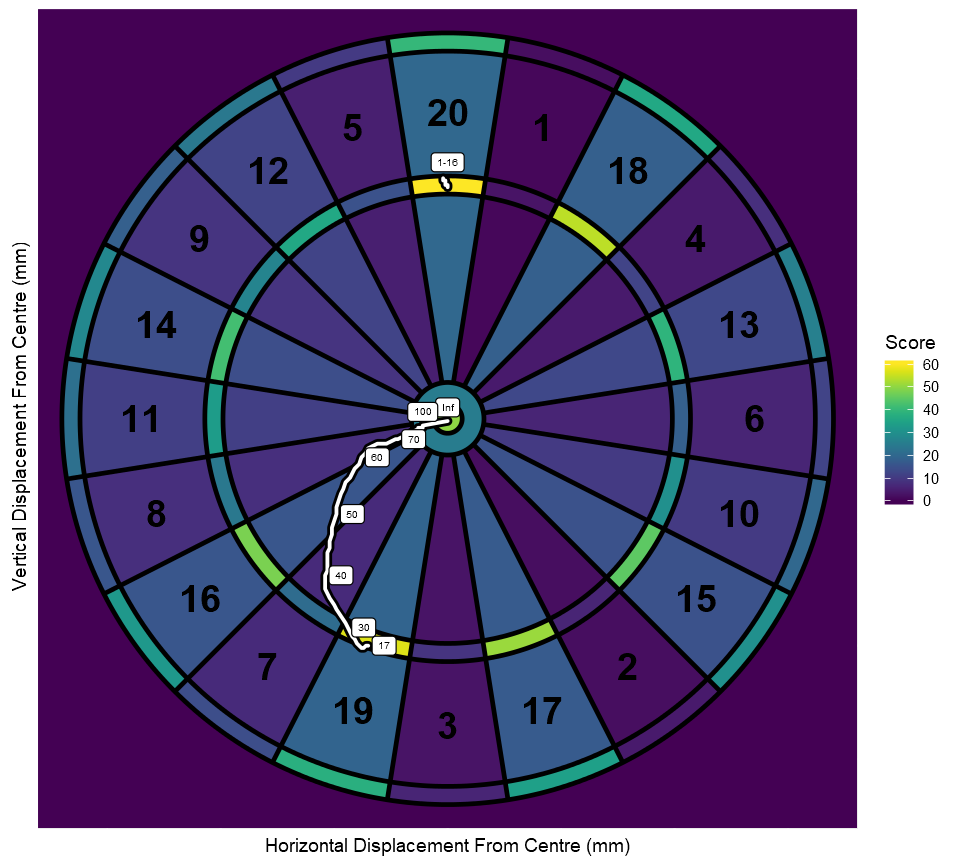

In [14]:
options(repr.plot.width=8, 
        repr.plot.height=7.2,
        jupyter.plot_mimetypes = "image/png")

# add extra row to optimums representing sd = infinity
optimums_extended <- optimums
optimums_extended[nrow(optimums) + 1,] = list(0, -1, NA, NA)
optimums_extended <- mutate(optimums_extended, group = as.integer(y > 0))
# points to add automatic annotations at
annotation_selections <- c(17, 30, 40, 50, 60, 70)

ggplot() +
  geom_raster(data = score.df, aes(x = x, y = y, fill = z)) +
  dart_board_layout +
  geom_path(data = optimums_extended, aes(x = x, y = y, group = group), size = 2, col = "black", lineend = "round") +
  geom_path(data = optimums_extended, aes(x = x, y = y, group = group), size = 0.8, col = "white", lineend = "round") + 
  # manual annotations
  annotate("label", x = 0, y = 113, label = "1-16", size = 2, col = "black", fill = "white") +
  annotate("label", x = 0, y = 5, label = "Inf", size = 2, col = "black", fill = "white") +
  geom_label(data = filter(optimums_extended, sd == 100), aes(x = x, y = y, label = sd), size = 2, col = "black", fill = "white", nudge_y = 6) +
  geom_label(data = filter(optimums_extended, sd %in% annotation_selections), aes(x = x, y = y, label = sd), size = 2, col = "black", fill = "white", nudge_x = 7)

This follows the behaviour that we described before, with the exact jump from treble 20 to treble 19 occurring at a standard deviation of 17mm. It can also be seen that the approach to the center slows as the standard deviation increases.

### Tracking the optimum score

It is now sensible to ask what the optimum obtainable expected score is for each standard deviation. We can look at this using the following visualisation

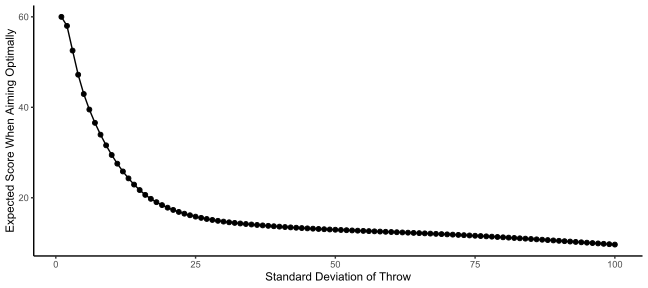

In [15]:
options(repr.plot.width=9, 
        repr.plot.height=4,
        jupyter.plot_mimetypes = "image/svg+xml")

ggplot(optimums, aes(x = sd, y = z)) +
  geom_line() +
  geom_point() +
  labs(x = "Standard Deviation of Throw",
       y = "Expected Score When Aiming Optimally") +
  theme_classic()

It it evident from this plot, that the game of darts has a definite 'skill elbow'. For small standard deviations, the expected score is extremely high but as soon as you start increasing this, the score drops off massively until it begins to stabilise at around 20mm. Then as you increase standard deviation more the expected optimum score only slightly reduces and will eventually tail off to zero. 

This shows that darts is a game where the difference between a terrible player and a mediocre player is not that severe, but the difference between that same mediocre player and a good player manifests itself savagely, creating a completely one-sided game.

## Estimating Your Standard Deviation

This analysis is all well and good but without a way to calculate your own standard deviation it has no use in practice. I have therefore developed a test to estimate your standard deviation. This involves throwing 100 darts aimed exactly at the centre of the bullseye and recording how many of them lie within the outer bull ring (either the bullseye itself or the ring around it). It can be shown using an appropriate statistical transformation that the radius squared of two independent normal variables with mean zero and equal standard deviation $\sigma$ is distributed exponentially with rate parameter $\frac{1}{2\sigma^2}$. Using this, we can calculate for any standard deviation the probability that a throw aimed at the centre will land within the outer bull. We can then use this probability as a parameter for a binomial random variable representing the number of times we land inside the outer bull in 100 throws. By reversing this process, first estimating the binomial probability parameter from our sample and then using the cumulative density function of the exponential function, we can estimate the standard deviation for any given number of outer bull hits.

If all of that seemed very complicated, don't worry. Understanding the statistics behind where the standard deviations come from is not necessary for using the outcome of it in practice. The results of the above method can simply be read off from the following table.

In [17]:
sds <- data.frame(hits = 100:1)

# function to estimate sd from number of hits
calc_sd <- function(hits){
  p <- hits / 100
  lambda <- -log(1 - p) / 16^2
  sd <- sqrt(1 / (2 * lambda))
  return(sd)
}

# create data frame of estimates
sds <- mutate(sds, sd = round(calc_sd(hits), 1),
              x = filter(optimums, sd == round(sd, 0))$x,
              y = filter(optimums, sd == round(sd, 0))$y,
              z = round(filter(optimums, sd == round(sd, 0))$z, 1))

sds

hits,sd,x,y,z
<int>,<dbl>,<int>,<int>,<dbl>
100,0.0,0,102,60.0
99,5.3,0,102,58.0
98,5.7,0,102,52.5
97,6.0,0,102,47.2
96,6.3,0,103,42.9
95,6.5,0,103,39.5
94,6.7,0,103,36.6
93,6.9,0,103,33.9
92,7.1,-1,103,31.6


If 100 throws seems like too many to bother with, you will get a similiar - though less precise - result by taking 25 or 50 throws and then multplying your number of hits by 4 or 2 respectively to simulate 100 throws.

Recalling the plot of optimum expected score vs. standard deviation, we saw that you need a standard deviation of less than around 20mm to pass the skill elbow and become a good darts player. From the table above, we see that for this to be the case, you would be expected to hit the outer bull at least 28 times out of the 100 hits. Do this hold for you?